In [672]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import spearmanr, pearsonr
from scipy.stats import chi2_contingency

In [634]:
# Lade die bereinigten Parquet-Dateien
df_damage = pd.read_parquet("transformed_damage_first.parquet")
df_label = pd.read_parquet("transformed_label_first.parquet")

In [636]:
df_damage.head(10)

,damage,cash_desk,total_amount,n_lines,payment_medium,has_feedback,feedback_categorical,feedback_low,feedback_middle,feedback_high,...,has_snacks,has_alcohol,has_fruits_vegetables_pieces,has_limited_time_offers,has_missing,mean_time_between_scans,max_time_between_scans,time_to_first_scan,time_from_last_scan_to_end,days_since_sco_introduction
0,0.0,2,13.12,3,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,9.387875,10.583388,9.058792,15.873231,0
1,0.0,1,11.52,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,False,False,False,3.359838,4.729999,2.521944,7.609351,0
2,0.0,2,7.92,2,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,11.349666,11.349666,2.777601,10.821077,0
3,0.0,1,209.17,21,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,7.644550,15.232503,7.469778,6.994438,0
4,0.0,1,130.68,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,7.904591,9.409289,6.085485,8.007759,0
5,0.0,1,97.76,5,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,3.134099,6.108651,4.825217,12.681974,0
6,0.0,3,146.61,13,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,4.339333,10.758632,0.706293,12.097396,0
7,0.0,1,19.69,2,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,1.060722,1.060722,10.068779,11.692407,0
8,0.0,2,41.56,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,5.047066,9.193132,4.432973,17.949444,0
9,0.0,1,48.47,6,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,9.155678,14.329252,5.139536,9.649522,0


In [650]:
df_label.head(10)

,label,cash_desk,total_amount,n_lines,payment_medium,has_feedback,feedback_categorical,feedback_low,feedback_middle,feedback_high,...,has_snacks,has_alcohol,has_fruits_vegetables_pieces,has_limited_time_offers,has_missing,mean_time_between_scans,max_time_between_scans,time_to_first_scan,time_from_last_scan_to_end,days_since_sco_introduction
0,NORMAL,1,7.14,2,CREDIT_CARD,True,HIGH,False,False,True,...,False,False,True,False,False,1.130303,1.130303,7.316038,13.294790,583
1,NORMAL,1,4.31,2,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,10.177853,10.177853,8.571641,4.578005,303
2,NORMAL,1,108.09,6,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,4.096605,7.836323,13.084929,10.449165,280
3,NORMAL,0,192.44,19,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,6.376875,12.956899,2.020288,12.295167,286
4,NORMAL,3,93.20,7,CREDIT_CARD,True,TOP,False,False,False,...,False,False,True,False,False,6.279699,13.548728,0.848289,12.563902,622
5,NORMAL,0,16.42,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,7.950093,12.795202,9.499026,9.351887,466
6,NORMAL,3,21.71,5,CASH,False,MISSING,False,False,False,...,False,False,True,False,False,5.951757,9.238978,1.336132,10.519659,170
7,NORMAL,3,20.36,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,6.687708,12.844969,1.561507,7.652387,50
8,NORMAL,3,740.92,68,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,False,5.328810,16.872367,1.601587,6.910045,59
9,NORMAL,1,134.26,16,CREDIT_CARD,True,LOW,True,False,False,...,False,False,True,False,False,6.886223,13.081432,8.689787,12.711985,518


In [665]:
df_damage.size

7993296

In [620]:
# Downsampling: 50% / 50% FRUAD / NORMAL bei label
#n_fraud_label = df_label[df_label["label"] == "FRAUD"].shape[0]
#n_nofraud_label = df_label[df_label["label"] == "NORMAL"].shape[0]
#n_available = min(n_fraud_label, n_nofraud_label)#, 500)  # maximal 500, aber nicht mehr als vorhanden
#df_fraud = df_label[df_label["label"] == "FRAUD"].sample(n=n_available, random_state=42)
#df_nofraud = df_label[df_label["label"] == "NORMAL"].sample(n=n_available, random_state=42)
#df_label = pd.concat([df_fraud, df_nofraud]).sample(frac=1, random_state=42).reset_index(drop=True)

In [622]:
n_fraud_label

4655

In [623]:
# Downsampling: 50% / 50% damage größer / gleich Null bei damage
#n_fraud_damage = df_damage[df_damage["damage"] != 0].shape[0]
#n_nofraud_damage = df_damage[df_damage["damage"] == 0].shape[0]
#n_available = min(n_fraud_damage, n_nofraud_damage)#, 500)  # maximal 500, aber nicht mehr als vorhanden
#df_fraud = df_damage[df_damage["damage"] != 0].sample(n=n_available, random_state=42)
#df_nofraud = df_damage[df_damage["damage"] == 0].sample(n=n_available, random_state=42)
#df_damage = pd.concat([df_fraud, df_nofraud]).sample(frac=1, random_state=42).reset_index(drop=True)

In [626]:
n_fraud_damage

4655

In [628]:
# Gemeinsame Länge bestimmen
#min_len = min(len(df_damage), len(df_label))

In [630]:
# Trimmen auf gleiche Länge
#df_damage = df_damage.iloc[:min_len].reset_index(drop=True)
#df_label = df_label.iloc[:min_len].reset_index(drop=True)

In [640]:
# Dann gemeinsame Permutation
np.random.seed(42)
permutation = np.random.permutation(min_len)
perm_damage = np.random.RandomState(seed=42).permutation(len(df_damage))
perm_label = np.random.RandomState(seed=42).permutation(len(df_label))
df_damage = df_damage.iloc[perm_damage].reset_index(drop=True)
df_label = df_label.iloc[perm_label].reset_index(drop=True)

In [642]:
len(df_label)

148024

In [644]:
len(df_damage)

148024

In [610]:
# Aufteilen in Trainings- und Testdaten
df_damage_train, df_damage_test = train_test_split(df_damage, test_size=0.2, random_state=42)
df_label_train, df_label_test = train_test_split(df_label, test_size=0.2, random_state=42)

In [502]:
# Analysefunktion pro Feature
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationError, PerfectSeparationWarning

# Unterdrücke Warnungen dieser Art
warnings.simplefilter("ignore", PerfectSeparationWarning)

def analyze_feature_general(df_train, df_test, feature, target_name):
    result = {"feature": feature}
    significance_label = "nicht signifikant"

    try:
        y_train = df_train[target_name]
        y_test = df_test[target_name]

        # Für Klassifikation: binäre Codierung
        if target_name == "label":
            y_train = y_train.map({"NORMAL": 0, "FRAUD": 1})
            y_test = y_test.map({"NORMAL": 0, "FRAUD": 1})

        # Feature vorbereiten
        X_train = df_train[[feature]].copy()
        X_test = df_test[[feature]].copy()

        is_categorical = (
            X_train[feature].dtype in ["object", "bool", "category"]
            or df_train[feature].nunique() <= 10
        )

        if is_categorical:
            X_train = pd.get_dummies(X_train, drop_first=True)
            X_test = pd.get_dummies(X_test, drop_first=True)
            X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

        X_train = X_train.astype("float64")
        X_test = X_test.astype("float64")

        valid_train = np.isfinite(X_train).all(axis=1) & np.isfinite(y_train)
        valid_test = np.isfinite(X_test).all(axis=1) & np.isfinite(y_test)
        X_train = X_train[valid_train]
        y_train = y_train[valid_train]
        X_test = X_test[valid_test]
        y_test = y_test[valid_test]

        X_train_const = sm.add_constant(X_train)
        X_test_const = sm.add_constant(X_test)

        if target_name == "label":
            # Chi²-Test nur für kategoriale Merkmale mit einer Spalte
            if is_categorical and X_train.shape[1] == 1:
                try:
                    chi2_score_val, chi2_p_val = chi2(X_train, y_train)
                    result["chi2_score"] = float(chi2_score_val[0])
                    result["chi2_p_value"] = float(chi2_p_val[0])
                    if chi2_p_val[0] < 0.01:
                        significance_label = "sehr signifikant"
                    elif chi2_p_val[0] < 0.05:
                        significance_label = "weniger signifikant"
                except Exception as e:
                    result["chi2_score"] = np.nan
                    result["chi2_p_value"] = np.nan
                    result["error"] = f"Chi²-Fehler: {str(e)}"
            else:
                result["chi2_score"] = np.nan
                result["chi2_p_value"] = np.nan

            try:
                model = sm.Logit(y_train, X_train_const).fit(disp=False)
                y_test_pred = model.predict(X_test_const)
                pseudo_r2 = 1 - model.llf / model.llnull
                if not np.isfinite(pseudo_r2) or pseudo_r2 > 1e6:
                    pseudo_r2 = np.nan
                    result["model_type"] = "logit_unstable"

                result.update({
                    "pseudo_r2_test": pseudo_r2,
                    "accuracy_test": np.mean((y_test_pred > 0.5) == y_test),
                    "p_value_train": model.pvalues.iloc[1] if len(model.pvalues) > 1 else np.nan,
                    "n_obs_train": len(y_train),
                    "n_obs_test": len(y_test),
                    "model_type": result.get("model_type", "logit")
                })

                # Signifikanz bei kontinuierlichen Merkmalen aus Regression
                if not is_categorical and len(model.pvalues) > 1:
                    p_val = model.pvalues.iloc[1]
                    if p_val < 0.01:
                        significance_label = "sehr signifikant"
                    elif p_val < 0.05:
                        significance_label = "weniger signifikant"

            except PerfectSeparationError:
                result.update({
                    "pseudo_r2_test": np.nan,
                    "accuracy_test": np.nan,
                    "p_value_train": np.nan,
                    "n_obs_train": len(y_train),
                    "n_obs_test": len(y_test),
                    "model_type": "logit_perfect",
                    "error": "Perfect separation – Modell nicht identifizierbar"
                })

        else:
            # Regressionsmodell (z. B. damage)
            model = sm.OLS(y_train, X_train_const).fit()
            y_train_pred = model.predict(X_train_const)
            y_test_pred = model.predict(X_test_const)

            correlation = np.nan
            if X_test.shape[1] == 1:
                correlation = np.sqrt(abs(r2_score(y_test, y_test_pred))) * np.sign(np.corrcoef(X_test.iloc[:, 0], y_test)[0, 1])

            het_pval = sm.stats.diagnostic.het_breuschpagan(model.resid, X_train_const)[1] if X_train_const.shape[1] > 1 else np.nan

            result.update({
                "r2_train": r2_score(y_train, y_train_pred),
                "r2_test": r2_score(y_test, y_test_pred),
                "correlation_test": correlation,
                "p_value_train": model.pvalues.iloc[1] if len(model.pvalues) > 1 else np.nan,
                "heteroskedasticity_pval_train": het_pval,
                "normality_pval_train": stats.normaltest(model.resid)[1] if len(model.resid) >= 8 else np.nan,
                "n_obs_train": len(y_train),
                "n_obs_test": len(y_test),
                "model_type": "ols",
                "chi2_score": np.nan,
                "chi2_p_value": np.nan
            })

            # Signifikanz
            if len(model.pvalues) > 1:
                p_val = model.pvalues.iloc[1]
                if p_val < 0.01:
                    significance_label = "sehr signifikant"
                elif p_val < 0.05:
                    significance_label = "weniger signifikant"

        result["significance"] = significance_label

    except Exception as e:
        result.update({
            "r2_train": np.nan,
            "r2_test": np.nan,
            "correlation_test": np.nan,
            "p_value_train": np.nan,
            "heteroskedasticity_pval_train": np.nan,
            "normality_pval_train": np.nan,
            "accuracy_test": np.nan,
            "pseudo_r2_test": np.nan,
            "n_obs_train": 0,
            "n_obs_test": 0,
            "model_type": "error",
            "chi2_score": np.nan,
            "chi2_p_value": np.nan,
            "significance": "nicht signifikant",
            "error": str(e)
        })

    # Relevanzbewertung nach Modellgüte
    relevance_label = "nicht relevant"

    if target_name == "label":
        if result.get("pseudo_r2_test", 0) >= 0.2:
            relevance_label = "sehr relevant"
        elif result.get("pseudo_r2_test", 0) >= 0.05:
            relevance_label = "weniger relevant"
    else:
        if result.get("r2_test", 0) >= 0.1:
            relevance_label = "sehr relevant"
        elif result.get("r2_test", 0) >= 0.02:
            relevance_label = "weniger relevant"

    result["relevance"] = relevance_label

    return result



In [504]:
# Hauptschleife für beide Targets
# Hauptschleife für beide Targets
for target_name, df_train, df_test in [
    ("damage", df_damage_train, df_damage_test),
    ("label", df_label_train, df_label_test)
]:
    result_rows = []
    for feature in df_train.columns:
        if feature == target_name:
            continue
        result = analyze_feature_general(df_train, df_test, feature, target_name)
        result_rows.append(result)

    # Ergebnis abspeichern
    df_results = pd.DataFrame(result_rows)
    df_results.to_excel(f"feature_analysis_{target_name}.xlsx", index=False)

C:\Users\49152\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\49152\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


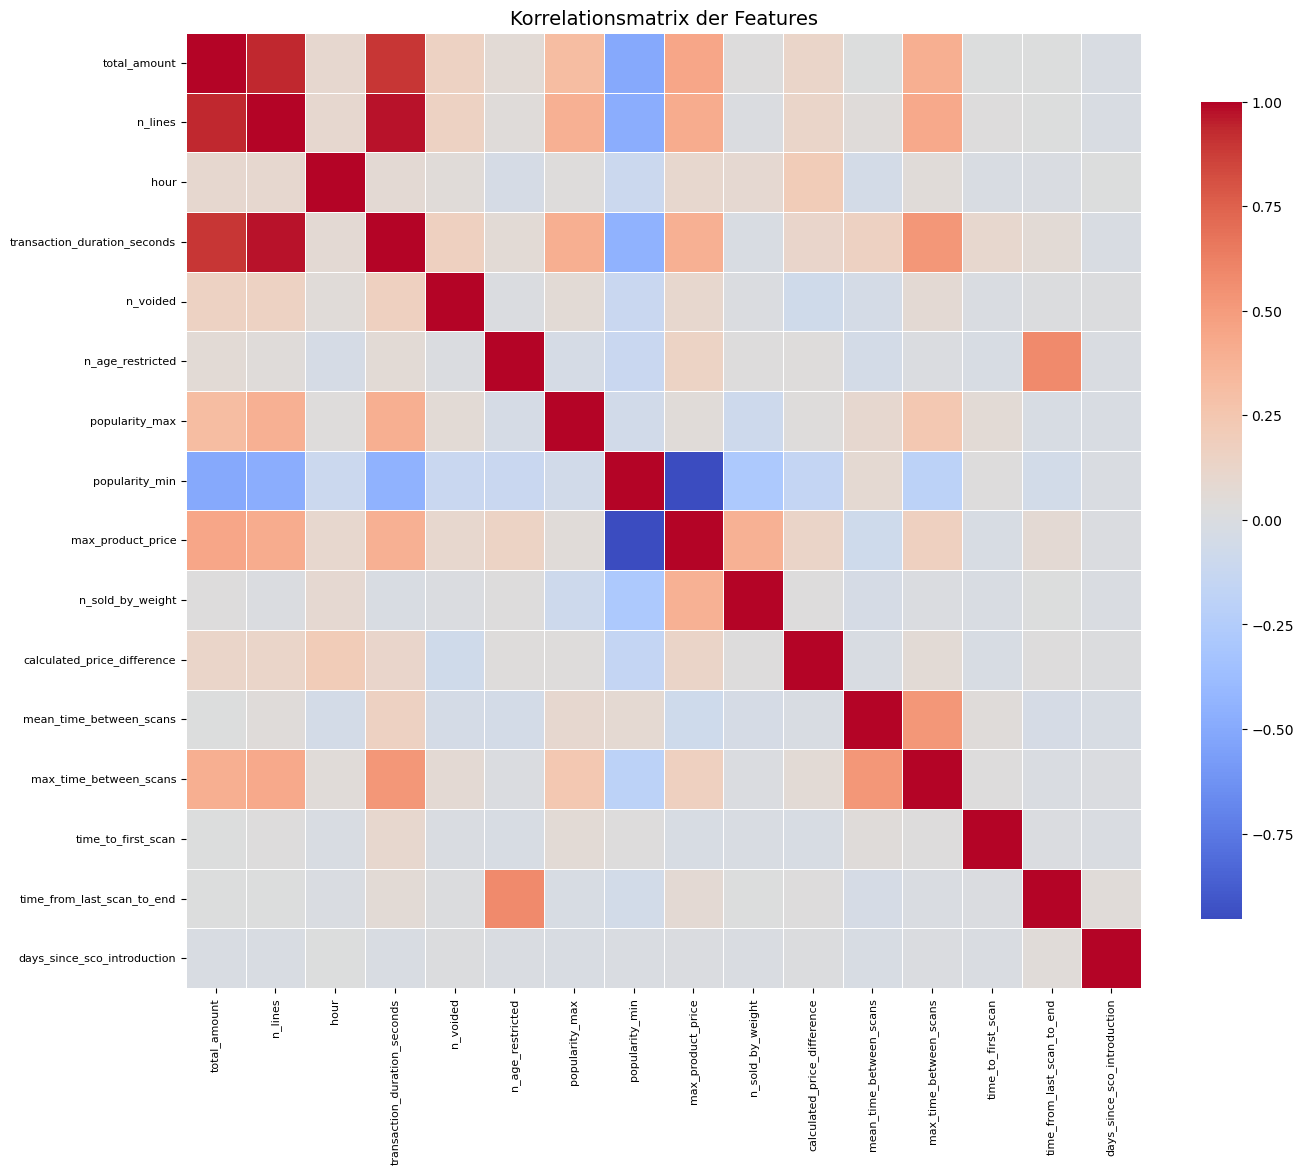

In [506]:
#Korrelationsmatrix der Features erstellen
df_features = df_damage.drop(columns=["damage"], errors="ignore")  # Zielspalte ggf. entfernen

# Kategorische Features in Dummies umwandeln
df_encoded = pd.get_dummies(df_features, drop_first= False)
df_numeric = df_encoded.select_dtypes(include=[np.number])

# Korrelationsmatrix berechnen
corr_matrix = df_numeric.corr()

# Plot vorbereiten
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            annot=False,
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.8})

# Achsenbeschriftungen rotieren
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Titel & Layout
plt.title("Korrelationsmatrix der Features", fontsize=14)
plt.tight_layout()
plt.show()

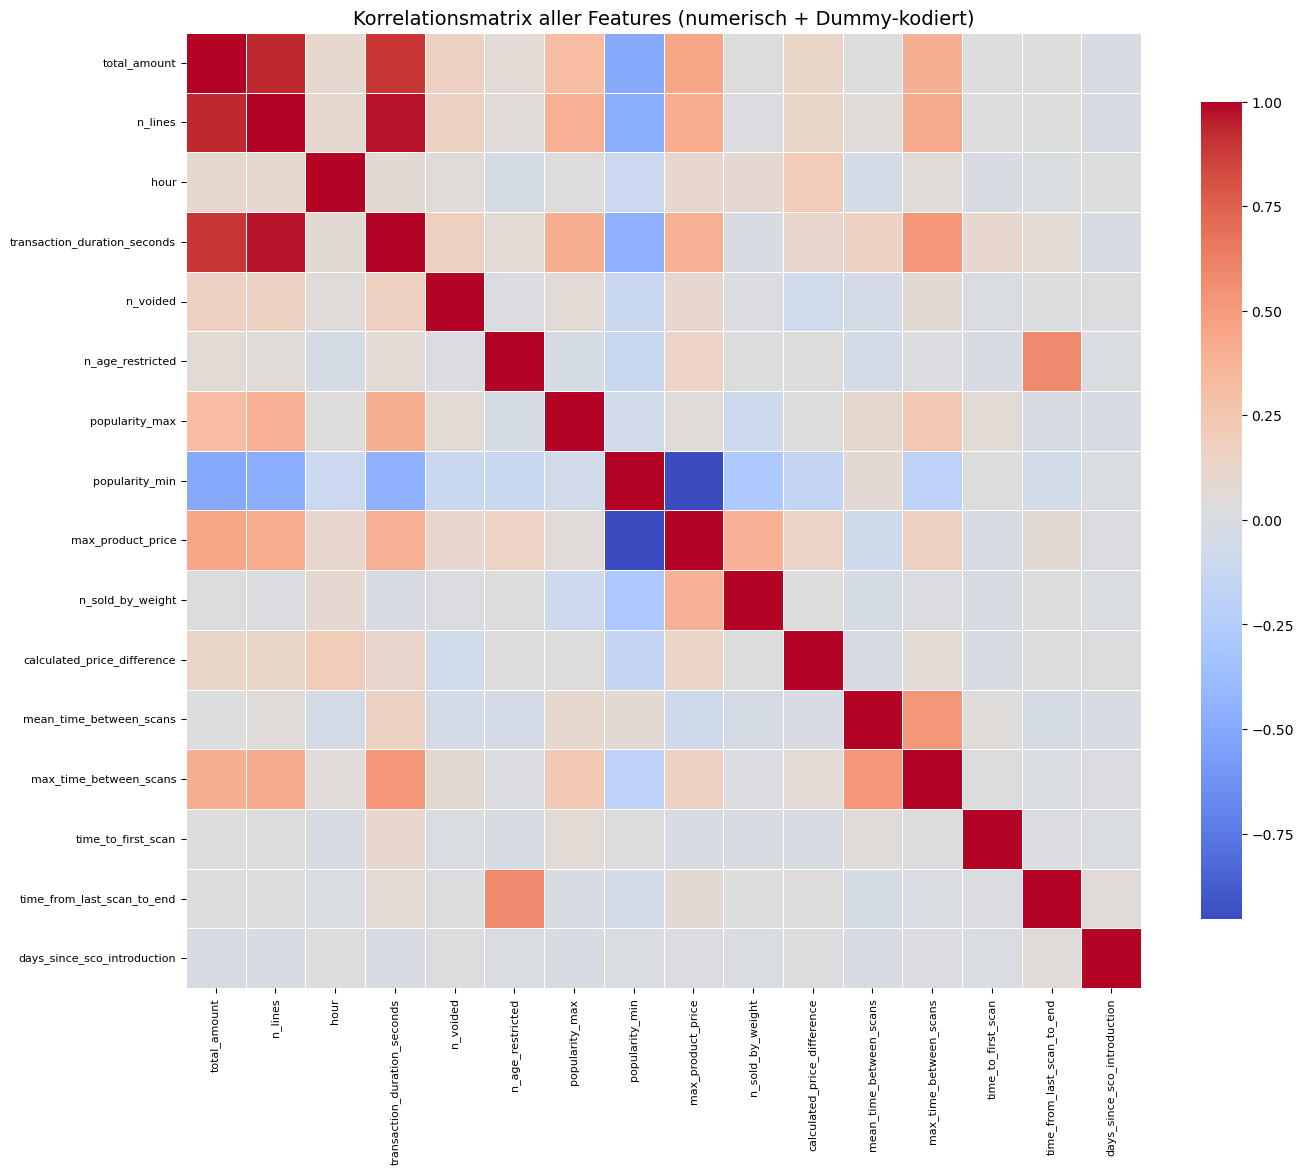

In [676]:
df_encoded = pd.get_dummies(df_features, drop_first=True)

#Nur numerische Spalten behalten
df_numeric = df_encoded.select_dtypes(include=[np.number])

#Entfernen der Spalten mit konstanter Ausprägung (Varianz = 0)
df_clean = df_numeric.loc[:, df_numeric.nunique() > 1]

#Korrelationsmatrix berechnen (Pearson)
corr = df_clean.corr()

#Plot erstellen
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5, square=True,
            xticklabels=True, yticklabels=True, cbar_kws={"shrink": 0.8})

plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.title("Korrelationsmatrix aller Features (numerisch + Dummy-kodiert)", fontsize=14)
plt.tight_layout()
plt.savefig("korrelationsmatrix.png", dpi=300)
plt.show()

In [510]:
original_features = df_features.columns.tolist()
encoded_features = df_encoded.columns.tolist()
used_in_heatmap = df_clean.columns.tolist()

print("Insgesamt erwartet:", len(original_features))
print("Nach Encoding:", len(encoded_features))
print("In Heatmap enthalten:", len(used_in_heatmap))

#fehlende
missing = [col for col in encoded_features if col not in used_in_heatmap]
print("Nicht enthalten in Heatmap (konstant oder leer):")
print(missing)

Insgesamt erwartet: 53
Nach Encoding: 95
In Heatmap enthalten: 16
Nicht enthalten in Heatmap (konstant oder leer):
['has_feedback', 'feedback_low', 'feedback_middle', 'feedback_high', 'feedback_top', 'has_voided', 'has_age_restricted', 'has_sold_by_weight', 'has_camera_detected_wrong_product', 'has_camera_detected_wrong_product_high_certainty', 'has_positive_price_difference', 'has_frozen_goods', 'has_beverages', 'has_dairy', 'has_bakery', 'has_fruits_vegetables', 'has_personal_care', 'has_household', 'has_tobacco', 'has_long_shelf_life', 'has_convenience', 'has_snacks', 'has_alcohol', 'has_fruits_vegetables_pieces', 'has_limited_time_offers', 'has_missing', 'cash_desk_1', 'cash_desk_2', 'cash_desk_3', 'payment_medium_CASH', 'feedback_categorical_TOP', 'feedback_categorical_HIGH', 'feedback_categorical_MIDDLE', 'feedback_categorical_LOW', 'daytime_noon', 'daytime_afternoon', 'daytime_evening', 'hour_categorical_9', 'hour_categorical_10', 'hour_categorical_11', 'hour_categorical_12', 'h

In [512]:
#Funktion bildet zunächst ein umfangreiches Modell inkl. polynomiellen Features und Interaktionstermen
#Dann wird die Funktionsgleichung schrittweise reduziert um irrelevante Parameter
def build_reduced_model(df, target_name, interaction_only, is_classification, degree, p_threshold):
    X = df.drop(columns=[target_name])
    y = df[target_name]

    # NaNs entfernen
    data = pd.concat([X, y], axis=1).dropna()
    X = data.drop(columns=[target_name])
    y = data[target_name]

    # Ziel binär kodieren, falls Klassifikation
    if is_classification:
        y = y.map({"FRAUD": 1, "NO_FRAUD": 0, "NORMAL": 0})

    # Dummy-Codierung + nur nicht-konstante Spalten
    X_dummies = pd.get_dummies(X, drop_first=True)
    X_dummies = X_dummies.loc[:, X_dummies.nunique() > 1]

    # Interaktionsterme 
    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=interaction_only)
    X_poly = poly.fit_transform(X_dummies)
    feature_names = poly.get_feature_names_out(X_dummies.columns)
    X_df = pd.DataFrame(X_poly, columns=feature_names, index=X_dummies.index)

    # Konstante hinzufügen
    X_df_const = sm.add_constant(X_df)

    # Split in Train/Test
    X_train, X_test, y_train, y_test = train_test_split(X_df_const, y, test_size=0.2, random_state=42)

    fallback_to_sklearn = False

    # Klassifikationsmodell
    if is_classification:
        try:
            model = sm.Logit(y_train, X_train).fit(disp=False)
            if not model.mle_retvals.get("converged", False):
                fallback_to_sklearn = True
        except Exception:
            fallback_to_sklearn = True

        if not fallback_to_sklearn:
            while True:
                pvals = model.pvalues.drop("const", errors="ignore")
                if pvals.empty or pvals.max() < p_threshold:
                    break
                drop = pvals.idxmax()
                X_train = X_train.drop(columns=[drop])
                X_test = X_test.drop(columns=[drop])
                try:
                    model = sm.Logit(y_train, X_train).fit(disp=False)
                    if not model.mle_retvals.get("converged", False):
                        fallback_to_sklearn = True
                        break
                except Exception:
                    fallback_to_sklearn = True
                    break

        if fallback_to_sklearn:
            model = LogisticRegression(solver="saga",max_iter=5000)
            X_train = X_train.drop(columns=["const"], errors="ignore")
            X_test = X_test.drop(columns=["const"], errors="ignore")
            model.fit(X_train, y_train)

        # Bewertung
        if fallback_to_sklearn:
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
        else:
            y_pred_train = (model.predict(X_train) > 0.5).astype(int)
            y_pred_test = (model.predict(X_test) > 0.5).astype(int)

        score_train = accuracy_score(y_train, y_pred_train)
        score_test = accuracy_score(y_test, y_pred_test)
        score_name = "accuracy"
        eval_result = {
            "confusion_train": pd.crosstab(y_train, y_pred_train, rownames=["Actual"], colnames=["Predicted"]),
            "confusion_test": pd.crosstab(y_test, y_pred_test, rownames=["Actual"], colnames=["Predicted"])
        }

    # Regressionsmodell
    else:
        model = sm.OLS(y_train, X_train).fit()
        while True:
            pvals = model.pvalues.drop("const", errors="ignore")
            if pvals.empty or pvals.max() < p_threshold:
                break
            drop = pvals.idxmax()
            X_train = X_train.drop(columns=[drop])
            X_test = X_test.drop(columns=[drop])
            model = sm.OLS(y_train, X_train).fit()

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Test-R² manuell
        ss_res_test = ((y_test - y_pred_test) ** 2).sum()
        ss_tot_test = ((y_test - y_test.mean()) ** 2).sum()
        score_test = 1 - ss_res_test / ss_tot_test

        score_train = model.rsquared
        score_name = "r²"

        mse_test = mean_squared_error(y_test, y_pred_test)
        mse_train = mean_squared_error(y_train, y_pred_train)
        eval_result = {
            "mse_test": mse_test,
            "rmse_test": np.sqrt(mse_test),
            "mse_train": mse_train,
            "rmse_train": np.sqrt(mse_train)
        }

    return {
        "final_model": model,
        "n_features": X_train.shape[1],
        "score_name": score_name,
        "score_test": score_test,
        "score_train": score_train,
        "features": X_train.columns.tolist(),
        "evaluation": eval_result,
        "used_fallback_model": fallback_to_sklearn
    }

In [678]:
#damage als Regressionsziel
#für komplexere Modelle einfach degree hochsetzen und interaction_only auf False setzen
res_damage = build_reduced_model(df_damage, target_name="damage", interaction_only=True, is_classification=False, degree=1, p_threshold=0.05)
#Ergebnisse ausgeben
print("Damage-Modell:")
print(f" R² Test:  {res_damage['score_test']:.3f}")
print(f" R² Train: {res_damage['score_train']:.3f}")
print(f"\n RMSE Test:  {res_damage['evaluation']['rmse_test']:.3f}")
print(f" RMSE Train: {res_damage['evaluation']['rmse_train']:.3f}")

# Export für Regressionsmodell (damage)
df_result_damage = pd.DataFrame({
    "feature": res_damage["features"],
    "included": True
})
df_result_damage["score_name"] = res_damage["score_name"]
df_result_damage["score_test"] = res_damage["score_test"]
df_result_damage["score_train"] = res_damage["score_train"]
df_result_damage["rmse_test"] = res_damage["evaluation"].get("rmse_test", np.nan)
df_result_damage["rmse_train"] = res_damage["evaluation"].get("rmse_train", np.nan)
df_result_damage["mse_test"] = res_damage["evaluation"].get("mse_test", np.nan)
df_result_damage["mse_train"] = res_damage["evaluation"].get("mse_train", np.nan)

df_result_damage.to_csv("model_result_damage.csv", index=False)

Damage-Modell:
 R² Test:  0.517
 R² Train: 0.529

 RMSE Test:  1.245
 RMSE Train: 1.287


In [680]:
#label als Klassifikationsziel
#für komplexere Modelle einfach degree hochsetzen und interaction_only auf False setzen
res_label = build_reduced_model(df_label, target_name="label", interaction_only=True, is_classification=True, degree=1, p_threshold=0.05)

#Ergebnisse ausgeben
print("\n Label-Modell:")
print(f" Accuracy Test:  {res_label['score_test']:.3f}")
print(f" Accuracy Train: {res_label['score_train']:.3f}")
print("\n Confusion Matrix Test:\n", res_label["evaluation"]["confusion_test"])
print("\n Confusion Matrix Train:\n", res_label["evaluation"]["confusion_train"])

# Export für Regressionsmodell (label)
df_result_label = pd.DataFrame({
    "feature": res_label["features"],
    "included": True
})
df_result_label["score_name"] = res_label["score_name"]
df_result_label["score_test"] = res_label["score_test"]
df_result_label["score_train"] = res_label["score_train"]
df_result_label["confusion_matrix_test"] = str(res_label["evaluation"]["confusion_test"].to_string())
df_result_label["confusion_matrix_train"] = str(res_label["evaluation"]["confusion_train"].to_string())

df_result_label.to_csv("model_result_label.csv", index=False)

C:\Users\49152\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Label-Modell:
 Accuracy Test:  0.974
 Accuracy Train: 0.974

 Confusion Matrix Test:
 Predicted    0.0  1.0
Actual               
0.0        28619   41
1.0          727  218

 Confusion Matrix Train:
 Predicted     0.0  1.0
Actual                
0.0        114532  177
1.0          2926  784


In [658]:
#Verteilungsanalyse und Ausreißer

# Numerische Features ermitteln
numerical_features = df_damage.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Gemeinsame Histogramme für damage=0 vs. damage>0
for feature in numerical_features:
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Verteilung von {feature} nach Schadenhöhe", fontsize=14)

    # Schaden = 0
    plt.subplot(1, 2, 1)
    sns.histplot(df_damage[df_damage["damage"] == 0][feature], kde=True, bins=30, color="skyblue")
    plt.title("damage = 0")

    # Schaden > 0
    plt.subplot(1, 2, 2)
    sns.histplot(df_damage[df_damage["damage"] > 0][feature], kde=True, bins=30, color="salmon")
    plt.title("damage > 0")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"eda_plots/hist_compare_damage_{feature}.png")
    plt.close()

#Vergleich label = FRAUD vs. NO_FRAUD, wenn label vorhanden
label_features = [f for f in numerical_features if f in df_label.columns]
for feature in label_features:
    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Verteilung von {feature} nach Label-Klasse", fontsize=14)

    # NO_FRAUD
    plt.subplot(1, 2, 1)
    sns.histplot(df_label[df_label["label"] == "NORMAL"][feature], kde=True, bins=30, color="lightgreen")
    plt.title("NO_FRAUD")

    # FRAUD
    plt.subplot(1, 2, 2)
    sns.histplot(df_label[df_label["label"] == "FRAUD"][feature], kde=True, bins=30, color="coral")
    plt.title("FRAUD")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"eda_plots/hist_compare_label_{feature}.png")
    plt.close()

# 2. Einzelne Boxplots
for feature in numerical_features:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df_damage[feature])
    plt.title(f"Boxplot von {feature}")
    plt.tight_layout()
    plt.savefig(f"eda_plots/box_{feature}.png")
    plt.close()

# 3. Z-Score-Ausreißer-Anzahl
outlier_summary = pd.DataFrame({
    "feature": numerical_features,
    "outliers_abs_zscore>3": [((np.abs(zscore(df_damage[f].dropna())) > 3).sum()) for f in numerical_features]
}).sort_values("outliers_abs_zscore>3", ascending=False)

outlier_summary.head(20)


,feature,outliers_abs_zscore>3
7,calculated_price_difference,3273
4,popularity_max,3193
1,total_amount,2962
3,transaction_duration_seconds,2947
2,n_lines,2906
9,max_time_between_scans,2204
11,time_from_last_scan_to_end,2167
0,damage,2111
6,max_product_price,2073
8,mean_time_between_scans,1386


In [664]:
os.makedirs("eda_nonlin", exist_ok=True)

for feature in numerical_features:
    if feature == "damage":
        continue
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_damage[feature], y=df_damage["damage"], alpha=0.1, s=10)
    
    smoothed = lowess(df_damage["damage"], df_damage[feature], frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOWESS')
    
    plt.title(f"{feature} vs. damage")
    plt.xlabel(feature)
    plt.ylabel("damage")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"eda_nonlin/lowess_{feature}_vs_damage.png")
    plt.close()

C:\Users\49152\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [668]:
corrs = []
for feature in numerical_features:
    if feature == "damage":
        continue
    pearson_corr = pearsonr(df_damage[feature], df_damage["damage"])[0]
    spearman_corr = spearmanr(df_damage[feature], df_damage["damage"])[0]
    corrs.append((feature, pearson_corr, spearman_corr))

df_corr = pd.DataFrame(corrs, columns=["feature", "pearson", "spearman"])
df_corr["diff"] = (df_corr["spearman"] - df_corr["pearson"]).abs()
df_corr = df_corr.sort_values("diff", ascending=False)

df_corr.to_csv("eda_nonlin/correlation_comparison.csv", index=False)

In [674]:
# kategoriale Attribute
# Ordner für die Plots erstellen
os.makedirs("eda_categorical", exist_ok=True)

# Kategoriale Spalten automatisch erkennen
categorical_features = df_label.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if "label" in categorical_features:
    categorical_features.remove("label")  # Zielspalte ausnehmen

# Barplots speichern
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_label, x=feature, order=df_label[feature].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Häufigkeit der Kategorien: {feature}")
    plt.tight_layout()
    plt.savefig(f"eda_categorical/barplot_{feature}.png")
    plt.close()

# Chi²-Test auf Zusammenhang mit label
chi2_results = []
for feature in categorical_features:
    contingency = pd.crosstab(df_label[feature], df_label["label"])
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        continue  # zu wenige Gruppen
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results.append((feature, chi2, p))

# Als DataFrame speichern
df_chi2 = pd.DataFrame(chi2_results, columns=["feature", "chi2", "p_value"])
df_chi2["significance"] = pd.cut(df_chi2["p_value"],
                                 bins=[-0.01, 0.01, 0.05, 1],
                                 labels=["*** sehr signifikant", "** signifikant", "n.s."])

# Exportieren
df_chi2.to_csv("eda_categorical/chi2_results.csv", index=False)